### Causal relation classification: using Pre-trained BERT model

### Causal relation classification: Trying to find is there a causal relation in the paragraph<br>

A fun example:
<img src="https://i1.wp.com/boingboing.net/wp-content/uploads/2020/11/Screen-Shot-2020-11-15-at-6.15.14-AM.png?fit=1208%2C786&ssl=1" style="width:400px;height:300px">

<br><br><br>
In this task, we will implement a bert model to classify whether a paragraph contains a causal relation. Instead of using the last hidden state([CLS] token from the last transformer layer) to do transfer learning in notebook *1.1.2-causal-relation-precense-Bert*, now we will start with a pre-trained BERT model and retrain the full model on our data. To illustrate the difference between this approach and *1.1.2-causal-relation-precense-Bert*, the only difference is the classifier(Bert uses Feed-forward Neural network with softmax, transfer learning approach uses Logistic regression with Sigmoid) and for this approach we re-train the bert based on the pre-trained model.

<img src="http://www.mccormickml.com/assets/BERT/padding_and_mask.png" style="width:600px;height:500px">

### 1. Data preparation

In [1]:
cd ..

F:\PythonJupyterStudy\CM\CM_Macro\SSIML2021-macro-precision


In [2]:
from collections import OrderedDict 
import itertools
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
from sklearn.utils import shuffle,resample
from sklearn.metrics import classification_report,confusion_matrix
from src.data.make_dataset import read_data_file,make_dataset
import time
import datetime
import seaborn as sns
import torch
import warnings
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler



warnings.filterwarnings('ignore')

In [3]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 2070 SUPER


In [4]:
assert os.path.isdir("csv"), 'The directory "csv" does not exist!'
assert os.path.isdir("txt"), 'The directory "txt" does not exist!'
map_contents = read_data_file("csv/Map_Contents-20200726.csv")
speech_contents = read_data_file("csv/Speech_Contents-20210520.txt")
speeches = read_data_file("csv/Speeches-20210520.txt")

In [5]:
X, y = make_dataset(speeches, speech_contents, map_contents)

skipping file in language fr: 2009-12-01 Sarkozy Elysee (Economy) ann fr.txt
skipping file in language fr: 2009-12-14 Sarkozy Elysee (Economy) ann fr.txt
skipping file in language fr: 2010-04-20 Barroso European Commission ann fr.txt
skipping file in language fr: 2011-01-13 Sarkozy gb ann.txt
skipping file in language nl: 2011-04-06 Rutte FD evenement ann NL.txt
skipping file in language nl: 2011-09-27 Rutte Rijksoverheid ann.txt
skipping file in language nl: 2011-10-28 Knot dnb_01 ANN NL.txt
skipping file in language de: 2012-01-06 Rutte CSU klausurtagung ann G.txt
skipping file in language unk: 2012-07-26 Barroso European Commission.txt
skipping file in language fr: 2012-08-30 Hollande SFM2020 ann fr.txt
skipping file in language fr: 2013-02-19 Hollande SFM2020 ann fr.txt
skipping file in language fr: 2013-04-17 Hollande SFM2020 ann fr.txt
skipping file in language de: 2013-11-21 Merkel Bundesregerung ann g.txt
skipping file in language de: 2014-02-27 Merkel Bundesregerung ann g.txt


### 2. Balance the data

1.First of all, there still are some *Missing value* paragraphs in our data, therefore we need to remove them. <br><br>
2.In addition, our data is highly imbalanced, that's means we have twice as many paragraphs with causal relations compared to paragraphs without causal relations. This issue would make our classifier guess a paragraph contains causal relation with a high probability because it would be less likely to make a mistake, but this is not what we want. Therefore we need to balance our data.<br>

<h1><center>Undersampling VS  Oversampling</center></h1>

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png)

There are two common methods of balancing data: Undersampling and Oversampling, the former refers to the random sampling from the class which contains more data in order to make the dataset balanced. The latter is to copy data points from the class with less data, then make the dataset balanced.<br><br>
Both methods have their advantages and disadvantages, where Undersampling will make us discard some existing data, which will cost our model some training opportunities given our small data size. Nonetheless, oversampling "manually" improves the accuracy of the model because some data appear twice in the dataset, which means that the data points that appear in the test set are likely to appear in the training set as well.

In [6]:
def balance_data(X,y):
    """
    remove Missing value first, then output two balanced dataset (Undersampling and Oversampling)
    Input: X,y before pre-processing
    Output: dataframes after removing missing value, Undersampling and Oversampling
    """
    df = pd.DataFrame({'X':pd.Series(X),'y':pd.Series(y)})
    print('{} na data found'.format(len(df[df['X'].isna() == True].index)))
    df = df.dropna()
    print('na data dropped')
    
    df_true = df[df['y'] == True]
    df_false = df[df['y'] == False] 
    
    #Upsampling, for the class with less data, copy some data 
    df_false_upsampled = resample(df_false,random_state=42,n_samples=len(df_true),replace=True)
    df_upsampled = pd.concat([df_false_upsampled,df_true])
    df_upsampled = shuffle(df_upsampled)
    
    print('We totally have {} data after oversampling '.format(len(df_upsampled)))
    
    #downsampling
    df_true_downsampled = resample(df_true,random_state=42,n_samples=len(df_false),replace=False)
    df_downsampled = pd.concat([df_true_downsampled,df_false])
    df_downsampled = shuffle(df_downsampled)
    print('We totally have {} data after Undersampling '.format(len(df_downsampled)))
    
    
    return df_upsampled,df_downsampled,df

In [8]:
df_upsampled,df_downsampled,df = balance_data(X,y)

19 na data found
na data dropped
We totally have 1282 data after oversampling 
We totally have 474 data after Undersampling 


### 3. Re-train a Pre-trained BERT model
Our first step is to tokenize the paragraphs -- break them up into word and subwords in the format BERT is comfortable with. This process contains adding [CLS] and [SEP] tokens as well as substituting tokens with their IDs (tokens2IDs). <br><br>After tokenization, tokenized is a list of paragraphs -- each paragraph is represented as a list of tokens. And we want BERT to process our examples all at once (as one batch). It's just faster that way. For that reason, we need to pad all lists to the same size, so we can represent the input as one 2-d array, rather than a list of lists (of different lengths). <br><br>However, if we directly send padded to BERT, that would slightly confuse it. We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. Finally, we will re-train the bert model then validate on eval_set, the corresponding visualization will be implemented as well.<br><br>Notes: The current approach will NOT be validated using k-fold cross validation method.

In [7]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return


def bert_cls(sentences,labels):
    
    """
    step1: Tokenization
    """
    
    print('Do step1: Tokenization\n')
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []
    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 128,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
    
    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    # Print sentence 0, now as a list of IDs.
    print('Check the original paragraph and converted paragrapg: ')
    print('Original: ', sentences[1])
    print('Token IDs:', input_ids[1])
    
    
    """
    step2: make dataset and split train_eval 
    """
    print('\nDo step2: make dataset and split train_eval\n')
    # Combine the training inputs into a TensorDataset.
    dataset = TensorDataset(input_ids, attention_masks, labels)
    # Create a 50-50 train-validation split.
    # Calculate the number of samples to include in each set.
    train_size = int(0.6 * len(dataset))
    val_size = len(dataset) - train_size
    # Divide the dataset by randomly selecting samples.
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    print('{:>5,} training samples'.format(train_size))
    print('{:>5,} validation samples'.format(val_size))
    
    
    """
    step3: create dataloader for both training and eval set
    """
    print('\nDo step3: create dataloader for both training and eval set\n')
    # The DataLoader needs to know our batch size for training, so we specify it 
    # here. For fine-tuning BERT on a specific task, the authors recommend a batch 
    # size of 16 or 32.
    batch_size = 32
    
    # Create the DataLoaders for our training and validation sets.
    # We'll take training samples in random order. 
    train_dataloader = DataLoader(
                train_dataset,  # The training samples.
                sampler = RandomSampler(train_dataset), # Select batches randomly
                batch_size = batch_size # Trains with this batch size.
            )
    
    # For validation the order doesn't matter, so we'll just read them sequentially.
    validation_dataloader = DataLoader(
                val_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = batch_size # Evaluate with this batch size.
            )
    
    
    """
    step4: load bert model
    """
    print('\nDo step4: load bert model\n')
    # Load BertForSequenceClassification, the pretrained BERT model with a single 
    # linear classification layer on top. 
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 2, # The number of output labels--2 for binary classification.
                        # You can increase this for multi-class tasks.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
        return_dict = False
    )
    
    # Tell pytorch to run this model on the GPU.
    model.cuda()
    
    
    """
    step5: check number of total params (optional), uncomment code below if you want to check.
    """
    # print('\nDo step5: check number of total params (optional), uncomment code below if you want to check\n')
    # # Get all of the model's parameters as a list of tuples.
    # params = list(model.named_parameters())
 
    # print('The BERT model has {:} different named parameters.\n'.format(len(params)))
    # 
    # print('==== Embedding Layer ====\n')
    # 
    # for p in params[0:5]:
    #     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    # 
    # print('\n==== First Transformer ====\n')
    # 
    # for p in params[5:21]:
    #     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    # 
    # print('\n==== Output Layer ====\n')
    # 
    # for p in params[-4:]:
    #     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
       
    
    """
    step6: set optimizer
    """
    #print('\nDo step6: set optimizer\n')
    # Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
    # I believe the 'W' stands for 'Weight Decay fix"
    optimizer = AdamW(model.parameters(),
                      lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                      eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                    )
    
    
    """
    step7: Create the learning rate scheduler and helper functions
    """
    #print('\nDo step7: Create the learning rate scheduler and helper functions\n')
    # Number of training epochs. The BERT authors recommend between 2 and 4. 
    # We chose to run for 4, but we'll see later that this may be over-fitting the
    # training data.
    epochs = 4
    # Total number of training steps is [number of batches] x [number of epochs]. 
    # (Note that this is not the same as the number of training samples).
    total_steps = len(train_dataloader) * epochs
    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    
    # Function to calculate the accuracy of our predictions vs labels
    def flat_accuracy(preds, labels):
        pred_flat = np.argmax(preds, axis=1).flatten()
        labels_flat = labels.flatten()
        return np.sum(pred_flat == labels_flat) / len(labels_flat)
    
    def format_time(elapsed):
        '''
        Takes a time in seconds and returns a string hh:mm:ss
        '''
        # Round to the nearest second.
        elapsed_rounded = int(round((elapsed)))
        
        # Format as hh:mm:ss
        return str(datetime.timedelta(seconds=elapsed_rounded))
    
    """
    step8: Training and evaluating
    """
    print('\nDo step8: Training and evaluating the model\n')
    #set random seed to keep consistency
    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)
    
    #store a number of quantities such as training and validation loss,validation accuracy, and timings.
    training_stats = []
    total_t0 = time.time()
    
    #store prediction and true labels
    train_logits = []
    eval_logits = []
    train_label = []
    eval_label = []
    # For each epoch...
    for epoch_i in range(0, epochs):
        
        # ========================================
        #               Training
        # ========================================
        
        # Perform one full pass over the training set.
    
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')
    
        # Measure how long the training epoch takes.
        t0 = time.time()
        # Reset the total loss for this epoch.
        total_train_loss = 0
        model.train()
        
        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
    
            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)
                
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
    
            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the 
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].long().to(device)
    
            model.zero_grad()        
            loss, logits = model(b_input_ids, 
                                 token_type_ids=None, 
                                 attention_mask=b_input_mask, 
                                 labels=b_labels)
            
            logits_ = logits.detach().cpu().numpy()
            label_ids_ = b_labels.to('cpu').numpy()
            
            #store prediction for the last epoch
            if epoch_i == 3:
                train_logits.extend(logits_)
                train_label.extend(label_ids_)
            total_train_loss += loss.item()
    
            # Perform a backward pass to calculate the gradients.
            loss.backward()
            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
            # Update parameters and take a step using the computed gradient.Update the learning rate.
            optimizer.step()
            scheduler.step()
    
        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)
    
        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))
            
        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.
    
        print("")
        print("Running Validation...")
        t0 = time.time()
        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()
        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0
        # Evaluate data for one epoch
        for batch in validation_dataloader:
            
            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using 
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].long().to(device)
            
            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        
    
                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                (loss, logits) = model(b_input_ids, 
                                       token_type_ids=None, 
                                       attention_mask=b_input_mask,
                                       labels=b_labels)
                
            # Accumulate the validation loss.
            total_eval_loss += loss.item()
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)
            if epoch_i ==3:
                eval_logits.extend(logits)
                eval_label.extend(label_ids)
            
        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))
    
        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )
    
    print("")
    print("Training complete!")
    
    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    
    
    """
    Final step: Evaluation and Visualization
    """
    
    print('\nDo Final step: Evaluation and Visualization\n')
    # Display floats with two decimal places.
    pd.set_option('precision', 2)
    # Create a DataFrame from our training statistics.
    df_stats = pd.DataFrame(data=training_stats)
    # Use the 'epoch' as the row index.
    df_stats = df_stats.set_index('epoch')
    # Display the table.
    #df_stats
    
    # Use plot styling from seaborn.
    #sns.set(style='darkgrid')
    
    # Increase the plot size and font size.
    #sns.set(font_scale=1.5)
    #plt.rcParams["figure.figsize"] = (12,6)
    
    # Plot the learning curve.
    plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
    plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
    
    # Label the plot.
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks([1, 2, 3, 4])
    
    plt.show()
    
    def convert_logits_tolabel(logits):
        pred = []
        for i in logits:
            if i[0]> i[1]:
                pred.append(0)
            else:
                pred.append(1)
        return pred
    
    train_pred = convert_logits_tolabel(train_logits)
    eval_pred = convert_logits_tolabel(eval_logits)
    
    #For evaluation data
    target_names = ['class 0', 'class 1']
    print(classification_report(train_label, train_pred, target_names=target_names))
    cm = confusion_matrix(train_label, train_pred)
    plot_confusion_matrix(cm, ['No causal relation', 'Has causal relation'], normalize=False)
    
    #For evaluation data
    print(classification_report(eval_label, eval_pred, target_names=target_names))
    cm = confusion_matrix(eval_label, eval_pred)
    plot_confusion_matrix(cm, ['No causal relation', 'Has causal relation'], normalize=False)
    
    return 

### Experiment on un-balanced data

In [9]:
#transform label to int
df.loc[df['y'] == 'True', 'y'] = 1
df.loc[df['y'] == 'False', 'y'] = 0
df.y = df.y.astype(int)

#get sentences and label, will use them to do the tokenization
sentences = df.X.values
labels = df.y.values

Do step1: Tokenization



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Check the original paragraph and converted paragrapg: 
Original:  if we are not able to provide europe with an economic government .
Token IDs: tensor([ 101, 2065, 2057, 2024, 2025, 2583, 2000, 3073, 2885, 2007, 2019, 3171,
        2231, 1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Do step8: Training and evaluating the model


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.62
  Training epcoh took: 0:00:06

Running Validation...
  Accuracy: 0.74
  Validation Loss: 0.57
  Validation took: 0:00:01

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.58
  Training epcoh took: 0:00:06

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.56
  Validation took: 0:00:01

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.55
  Training epcoh took: 0:00:06

Running Validation...
  Accuracy: 0.74
  Validation Loss: 0.56
  Validation took: 0:00:01

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.53
  Training epcoh took: 0:00:06

Running Validation...
  Accuracy: 0.74
  Validation Loss: 0.56
  Validation took: 0:00:01

Training complete!
Total training took 0:00:29 (h:mm:ss)

Do Final step: Evaluation and Visualization



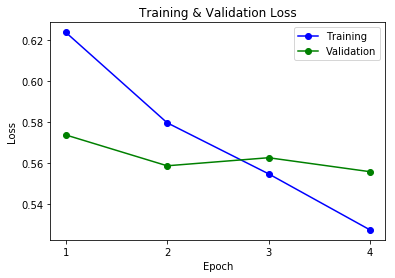

              precision    recall  f1-score   support

     class 0       0.89      0.17      0.28       145
     class 1       0.76      0.99      0.86       381

    accuracy                           0.76       526
   macro avg       0.82      0.58      0.57       526
weighted avg       0.79      0.76      0.70       526



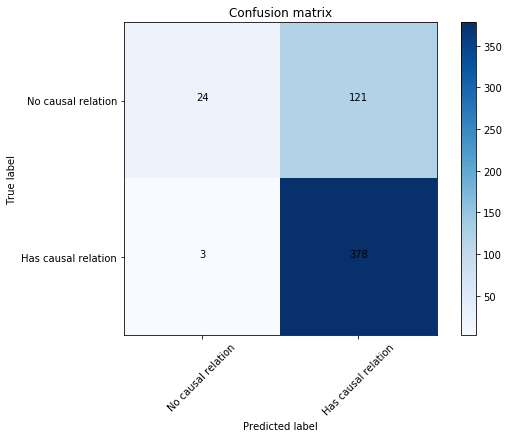

              precision    recall  f1-score   support

     class 0       0.56      0.05      0.10        92
     class 1       0.75      0.98      0.85       260

    accuracy                           0.74       352
   macro avg       0.65      0.52      0.47       352
weighted avg       0.70      0.74      0.65       352



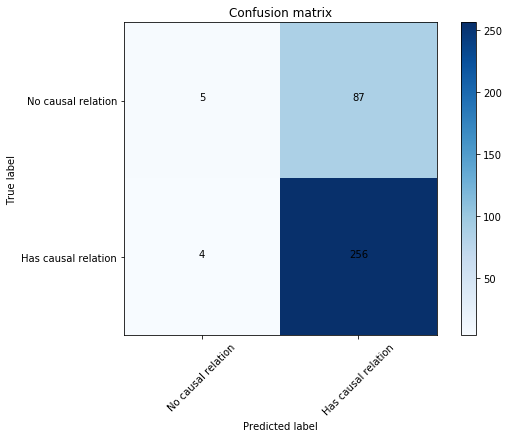

In [10]:
bert_cls(sentences,labels)

### Experiment on under-sampled data

In [11]:
#transform label to int
df_downsampled.loc[df['y'] == 'True', 'y'] = 1
df_downsampled.loc[df['y'] == 'False', 'y'] = 0
df_downsampled.y = df_downsampled.y.astype(int)

#get sentences and label, will use them to do the tokenization
sentences = df_downsampled.X.values
labels = df_downsampled.y.values

Do step1: Tokenization



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Check the original paragraph and converted paragrapg: 
Original:  i want to ask the question of the defense effort with regard to the stability pact . of course france , germany , italy and britain bear a considerable effort for protection but are we going to be able to continue for long to have four or five countries in europe that ensure the safety of all other and respect the same rules on deficits while many others do not have the defense budgets that we have ?
Token IDs: tensor([  101,  1045,  2215,  2000,  3198,  1996,  3160,  1997,  1996,  3639,
         3947,  2007,  7634,  2000,  1996,  9211, 14790,  1012,  1997,  2607,
         2605,  1010,  2762,  1010,  3304,  1998,  3725,  4562,  1037,  6196,
         3947,  2005,  3860,  2021,  2024,  2057,  2183,  2000,  2022,  2583,
         2000,  3613,  2005,  2146,  2000,  2031,  2176,  2030,  2274,  3032,
         1999,  2885,  2008,  5676,  1996,  3808,  1997,  2035,  2060,  1998,
         4847,  1996,  2168,  3513,  2006, 15074,  

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Do step8: Training and evaluating the model


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.70
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.60
  Validation Loss: 0.67
  Validation took: 0:00:01

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.64
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.69
  Validation Loss: 0.63
  Validation took: 0:00:01

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.60
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.71
  Validation Loss: 0.62
  Validation took: 0:00:01

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.56
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.72
  Validation Loss: 0.62
  Validation took: 0:00:01

Training complete!
Total training took 0:00:15 (h:mm:ss)

Do Final step: Evaluation and Visualization



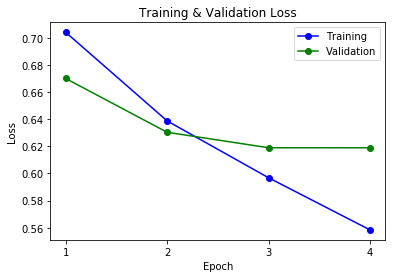

              precision    recall  f1-score   support

     class 0       0.77      0.64      0.70       146
     class 1       0.68      0.80      0.73       138

    accuracy                           0.72       284
   macro avg       0.72      0.72      0.72       284
weighted avg       0.73      0.72      0.72       284



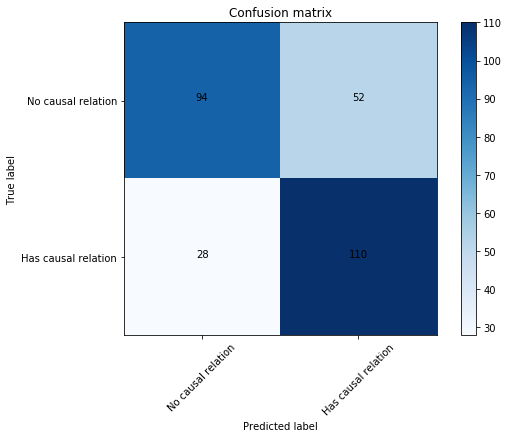

              precision    recall  f1-score   support

     class 0       0.70      0.70      0.70        91
     class 1       0.73      0.73      0.73        99

    accuracy                           0.72       190
   macro avg       0.72      0.72      0.72       190
weighted avg       0.72      0.72      0.72       190



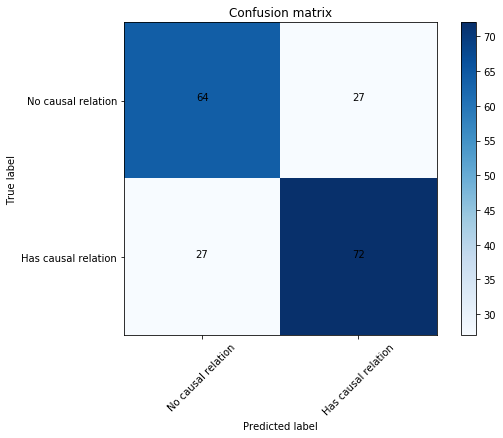

In [12]:
#Downsampling
bert_cls(sentences,labels)

### Experiment on over-sampled data

In [13]:
#transform label to int
df_upsampled.loc[df['y'] == 'True', 'y'] = 1
df_upsampled.loc[df['y'] == 'False', 'y'] = 0
df_upsampled.y = df_upsampled.y.astype(int)

#get sentences and label, will use them to do the tokenization
sentences = df_upsampled.X.values
labels = df_upsampled.y.values

Do step1: Tokenization



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Check the original paragraph and converted paragrapg: 
Original:  these proposals will provide real benefits to businesses and consumers through easing administrative burdens and lowering prices . we need more home-made growth in europe , and the single market must be updated and digitalized in order to achieve that . a good example of this is the roaming directive , which we managed to reach agreement on last month . with lower prices for cell phone usage , the directive extends a helping hand to companies that want to do cross-border business .
Token IDs: tensor([  101,  2122, 10340,  2097,  3073,  2613,  6666,  2000,  5661,  1998,
        10390,  2083, 24070,  3831, 10859,  2015,  1998, 13845,  7597,  1012,
         2057,  2342,  2062,  2188,  1011,  2081,  3930,  1999,  2885,  1010,
         1998,  1996,  2309,  3006,  2442,  2022,  7172,  1998,  3617,  3550,
         1999,  2344,  2000,  6162,  2008,  1012,  1037,  2204,  2742,  1997,
         2023,  2003,  1996, 24430, 16449,  10

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Do step8: Training and evaluating the model


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.66
  Training epcoh took: 0:00:09

Running Validation...
  Accuracy: 0.70
  Validation Loss: 0.60
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.56
  Training epcoh took: 0:00:09

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.52
  Validation took: 0:00:02

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.45
  Training epcoh took: 0:00:09

Running Validation...
  Accuracy: 0.78
  Validation Loss: 0.47
  Validation took: 0:00:02

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.36
  Training epcoh took: 0:00:09

Running Validation...
  Accuracy: 0.81
  Validation Loss: 0.44
  Validation took: 0:00:02

Training complete!
Total training took 0:00:43 (h:mm:ss)

Do Final step: Evaluation and Visualization



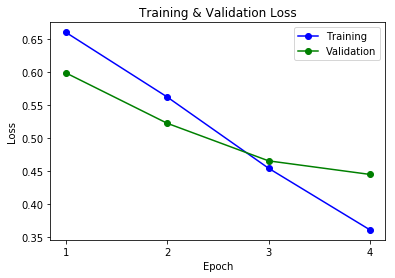

              precision    recall  f1-score   support

     class 0       0.90      0.83      0.87       363
     class 1       0.86      0.92      0.89       406

    accuracy                           0.88       769
   macro avg       0.88      0.88      0.88       769
weighted avg       0.88      0.88      0.88       769



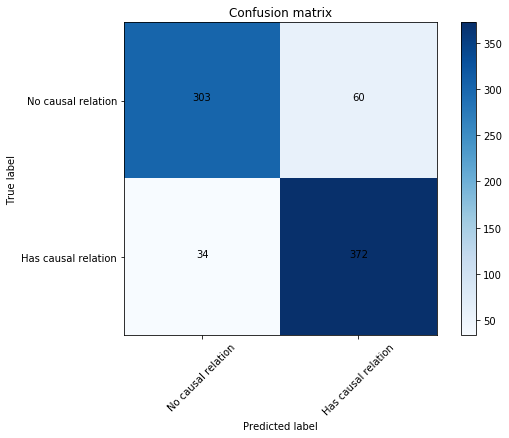

              precision    recall  f1-score   support

     class 0       0.82      0.80      0.81       278
     class 1       0.77      0.79      0.78       235

    accuracy                           0.79       513
   macro avg       0.79      0.79      0.79       513
weighted avg       0.79      0.79      0.79       513



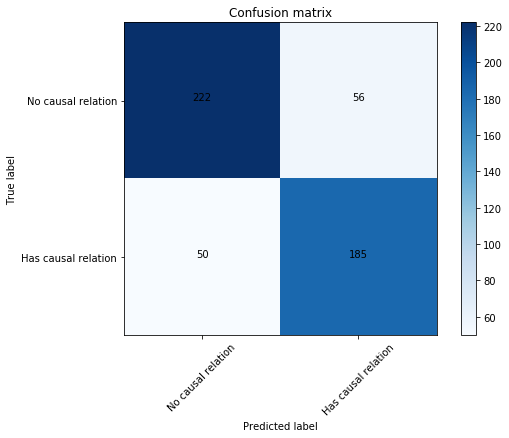

In [14]:
#Oversampling
bert_cls(sentences,labels)

## RESULT


Train/Eval| Balanced_data | macro precision | macro recall | macro F1|
 ----------| -----------------------| --------- | ------ | ---- |
Train            | no         | 0.82     | 0.58 | 0.57 |
Eval            | no   | 0.65     | 0.52 | 0.47 |
Train            | Undersampling   | 0.72     | 0.72 | 0.72 |
Eval            | Undersampling   | 0.72     | 0.72 | 0.72 |
Train            | Oversampling   | 0.88     | 0.88 | 0.88 |
Eval            | Oversampling   | 0.79    | 0.79 | 0.79 |


#### To sum up:<br>
* Attention is all you need! With oversampled data, Bert approach can achieve 0.77 macro F1 score.<br>
* However, both balancing methods have their advantages and disadvantages, where undersampling will make us discard some existing data, which will cost our model some training opportunities given our small data size. Nonetheless, oversampling "manually" improves the accuracy of the model because some data appear twice in the dataset, which means that the data points that appear in the test set are likely to appear in the training set as well.<br>
* The next step would be to try [fine-tuning](https://huggingface.co/transformers/examples.html#glue) once we have more data